# Constitutive modelling using JuliaFEM

Author(s): Jukka Aho

**Abstract**: This is reproduction of the results from notebook [*Ideal plastic Von Mises material*](https://github.com/JuliaFEM/JuliaFEM.jl/blob/master/notebooks/2015-09-24-Ideal%20plastic%20Von%20Mises%20material.ipynb) made by Olli Väinölä. Small strain theory is used, see https://en.wikipedia.org/wiki/Flow_plasticity_theory. The purpose of this notebook is to show how one can easily design and simulate material models using JuliaFEM. This is 2d version. For 3d version see Olli's notebook.

In [1]:
using JuliaFEM: IntegrationPoint, Field, FieldSet, TimeStep, Increment
using ForwardDiff
using PyPlot

The atomic structure here is `IntegrationPoint`. It has identical `Field`-structure like elements and can store multidimensional variables which can be time-dependent also. That way one can easily store, for example, measured strain and run material simulation for real measured data and fit material parameters.

In [2]:
ip = IntegrationPoint([0.0, 0.0], 1.0)

ip.fields["total strain"] = Field()
ip.fields["plastic strain"] = Field()
ip.fields["plastic potential"] = Field()
ip.fields["elastic strain"] = Field()
ip.fields["effective plastic strain"] = Field()
ip.fields["stress"] = Field()
ip.fields["young"] = Field(200.0e9)
ip.fields["poisson"] = Field(0.3)
ip.fields["yield stress"] = Field(200.0e6)
ip.fields["plastic rate parameter"] = Field(0.0) # material parameter

JuliaFEM.DefaultDiscreteField([JuliaFEM.TimeStep(0.0,JuliaFEM.Increment[[0.0]])])

Accessing parameters is done just like with `FieldSet`s in general:

In [3]:
info(last(ip.fields["young"]))
info(last(ip.fields["yield stress"]))

INFO: [2.0e11]
INFO: [2.0e8]


Next to material model: ideal plastic material model.

In [4]:
""" Ideal plastic material model. """
function calculate_stress!(ip::IntegrationPoint, strain::Matrix, time::Number)

    dim = size(strain, 1)
    
    poisson = last(ip.fields["poisson"])[1]
    young = last(ip.fields["young"])[1]
    mu = young/(2*(1+poisson))
    lambda = young*poisson/((1+poisson)*(1-2*poisson))
    if dim == 2
        lambda = 2*lambda*mu/(lambda + 2*mu)  # <- correction for 2d
    end

    # yield function
    function f(stress)
        # https://en.wikipedia.org/wiki/Yield_surface
        # https://en.wikipedia.org/wiki/Von_Mises_yield_criterion
        stress_y = last(ip.fields["yield stress"])[1]
        s1 = stress[1,1]
        s2 = stress[2,2]
        s12 = stress[1,2]
        stress_v = sqrt(s1^2 - s1*s2 + s2^2 + 3*s12^2)
        return stress_v - stress_y
    end

    strain_plastic_prev = last(ip.fields["plastic strain"])[1]
    strain_elastic = strain - strain_plastic_prev
    stress_trial = lambda*trace(strain_elastic)*I + 2*mu*(strain_elastic)

    if f(stress_trial) <= 0.0
        #info("time=$time: no yield")
        push!(ip.fields["stress"], TimeStep(time, Increment(Matrix[stress_trial])))
        push!(ip.fields["total strain"], TimeStep(time, Increment(Matrix[strain])))
        return true
    else
        #info("time=$time: yield, f(stress_trial) = $(f(stress_trial))")
        dt = time - ip.fields["total strain"][end].time

        # associated flow rule, plastic potential ψ(σ) = f
        psi = f

        """ Calculate equations

            dσ - C (dϵₜ - dγ*dΨ/dσ) = 0
                         σₑ(σ) - σy = 0

            dϵₜ = total strain
            dϵₑ = elastic strain
            dϵₚ = plastic strain
        
            dϵₜ = dϵₑ + dϵₚ
            => dϵₑ = dϵₜ - dϵₚ = dϵₜ - dγ*dψ/dσ
            dσ = λ⋅tr(dϵₑ)I + 2μ⋅dϵₑ
            => dσ - λ⋅tr(dϵₑ)I - 2μ⋅dϵₑ = 0
        """
        function residual(params::Vector)
            dstress = reshape(params[1:prod(size(strain))], size(strain))
            gamma = params[end]
            strain_prev = last(ip.fields["total strain"])[1]
            stress_prev = last(ip.fields["stress"])[1]
            dstrain_total = 1/dt*(strain - strain_prev)
            stress_tot = stress_prev + dstress
            # derivative of plastic potential ψ(σ) w.r.t 2nd order tensor σ(ϵ)
            # https://en.wikipedia.org/wiki/Tensor_derivative_%28continuum_mechanics%29
            # "Derivatives of scalar valued functions of second-order tensors"
            dpsi_dstress = derivative(psi, stress_tot)
            dstrain_plastic = gamma*dpsi_dstress
            dstrain_elastic = dstrain_total - dstrain_plastic
            dstress_elastic = lambda*trace(dstrain_elastic)*I + 2*mu*dstrain_elastic
            stress_delta = dstress - dstress_elastic
            return [vec(stress_delta); psi(stress_tot)]
        end

        # solve equations using Newton iterations. Jacobian is calcualated
        # using automatic differentiation as usual.
        stress_prev = last(ip.fields["stress"])[1]
        initial_gamma = last(ip.fields["plastic rate parameter"])[1]
        params = [vec(stress_prev); initial_gamma]
        dparams = zeros(5)
        l = [1, 4, 3, 5] # <-- reorder to voigt
        for iterations=1:10
            A = ForwardDiff.jacobian(residual, params)[l,l]
            b = -residual(params)[l]
            dparams = A \ b
            params[l] += dparams
            norm(dparams) < 1.0e-7 && break
        end
        params[2] = params[3]

        # save all kind of stuff to integration point

        dstress = reshape(params[1:prod(size(strain))], size(strain))
        stress = stress_prev + dstress
        dpsi_dstress = derivative(psi, stress)
        gamma = params[end]
        dstrain_plastic = gamma*dpsi_dstress
        strain_plastic_prev = last(ip.fields["plastic strain"])[1]
        strain_plastic  = strain_plastic_prev + dstrain_plastic

        push!(ip.fields["stress"], TimeStep(time, Increment(Matrix[stress])))
        push!(ip.fields["total strain"], TimeStep(time, Increment(Matrix[strain])))
        push!(ip.fields["elastic strain"], TimeStep(time, Increment(Matrix[strain_elastic])))
        push!(ip.fields["plastic strain"], TimeStep(time, Increment(Matrix[strain_plastic])))
        push!(ip.fields["plastic rate parameter"], TimeStep(time, Increment(params[end])))
        push!(ip.fields["plastic potential"], TimeStep(time, Increment(psi(stress))))
        push!(ip.fields["derivative of plastic potential"], TimeStep(time, Increment(Matrix[dpsi_dstress])))
    end

end

calculate_stress! (generic function with 1 method)

Small "simulator" to study the behavior of material model in `IntegrationPoint`.

In [6]:
function run(steps=11)

    # initialization
    ip = IntegrationPoint([0.0, 0.0], 1.0)
    ip.fields["total strain"] = Field()
    ip.fields["plastic strain"] = Field(Matrix[zeros(2,2)])
    ip.fields["plastic potential"] = Field()
    ip.fields["derivative of plastic potential"] = Field()
    ip.fields["elastic strain"] = Field()
    ip.fields["effective plastic strain"] = Field()
    ip.fields["stress"] = Field()
    ip.fields["young"] = Field(200.0e9)
    ip.fields["poisson"] = Field(0.3)
    ip.fields["yield stress"] = Field(200.0e6)
    ip.fields["plastic rate parameter"] = Field(0.0) # material parameter

    strain = zeros(2, 2)
    strain[1,1] = 2.0e-3
    strain[2,2] = -0.3*2.0e-3
    #strain[1,2] = 1.0e-3
    #strain[2,1] = 1.0e-3

    # calculate stress in integration point
    #for (time, omega) in enumerate(linspace(0, 4*pi, steps))
    #    calculate_stress!(ip, sin(omega)*strain, Float64(time))
    #end

    for (time, k) in enumerate(linspace(0, 1, steps))
        calculate_stress!(ip, k*strain, Float64(time))
    end

    return ip
end

tic()
ip = run()
toc();

elapsed time: 0.031678742 seconds


Visualize results:

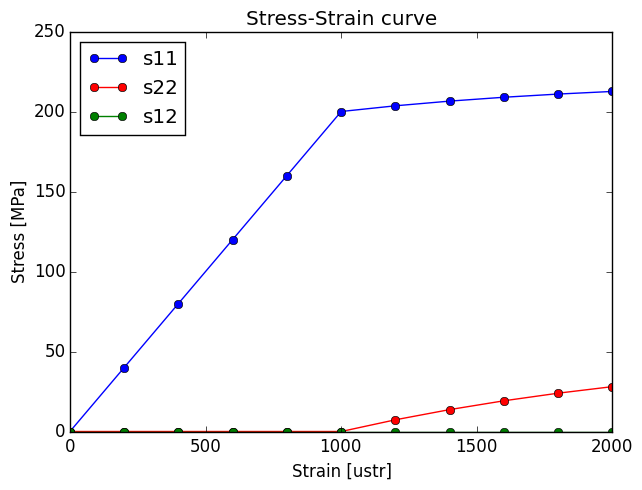

PyObject <matplotlib.legend.Legend object at 0x7fa8a16155d0>

In [7]:
steps = length(ip.fields["total strain"])
eps11 = Float64[]
sig11 = Float64[]
sig22 = Float64[]
sig12 = Float64[]
principals = Vector{Float64}[]
for i=1:steps
    # extract from integration points
    # field -> timestep -> increment -> (vector of tensors, take first) -> (first component)
    strain = ip.fields["total strain"][i][end][1]*1.0e6
    stress = ip.fields["stress"][i][end][1]*1.0e-6
    push!(eps11, strain[1,1])
    push!(sig11, stress[1,1])
    push!(sig22, stress[2,2])
    push!(sig12, stress[1,2])
    push!(principals, eigvals(stress))
end

PyPlot.figure(figsize=(7, 5))
PyPlot.plot(eps11, sig11, "-bo", label="s11")
PyPlot.plot(eps11, sig22, "-ro", label="s22")
PyPlot.plot(eps11, sig12, "-go", label="s12")
PyPlot.title("Stress-Strain curve")
PyPlot.xlabel("Strain [ustr]")
PyPlot.ylabel("Stress [MPa]")
#PyPlot.ylim([-250, 250])
#PyPlot.xlim([-2100, 2100])
PyPlot.legend(loc="best")

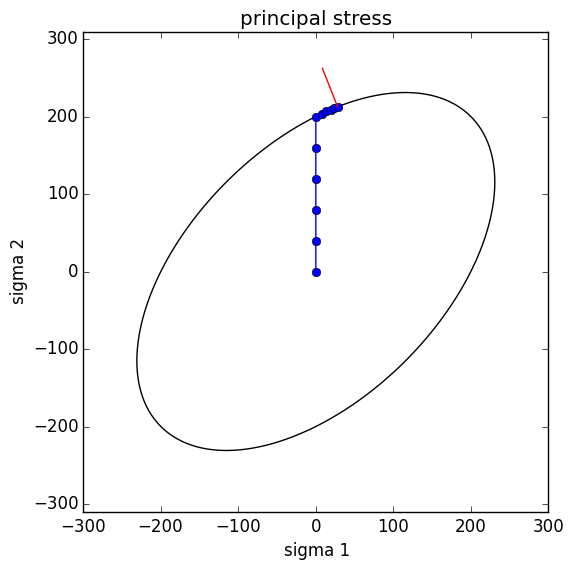

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa8a1513050>

In [8]:
function plot_principal()
    PyPlot.figure(figsize=(6, 6))
    n = 100
    s = linspace(-300, 300, n)
    s1 = repmat(s', n, 1)
    s2 = repmat(s, 1, n)
    sigma = sqrt(s1.^2 + s2.^2 - s1.*s2)
    contour(s1, s2, sigma, [200], colors="k")
    p1 = [p[1] for p in principals]
    p2 = [p[2] for p in principals]
    PyPlot.plot(p1, p2, "-bo")
    axis("equal")
    xlabel("sigma 1")
    ylabel("sigma 2")
    title("principal stress")
    dir = last(ip.fields["derivative of plastic potential"])[1]
    PyPlot.plot([p1[end], p1[end]+dir[2,2]*50],
                [p2[end], p2[end]+dir[1,1]*50], "-r")
end
plot_principal()